# New approach to evaluating models  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to establish a new approach to evaluating models for this contest.  I propose a method which borrows from the **K-Folds** and **Leave-one-out** methods, wherein we build the model several times; each model is built by leaving out one well as the test set.

Time to load supporting libraries and the data!  We'll also extract the **Shankle** well from the training data into a blind data set to be used for testing our final model.

In [8]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# machine learning packages
library(e1071)
library(caret)

In [2]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# convert NM_M channel into a binary channel "isMarine"
data$NM_M <- data$NM_M == "2"
names(data)[10] <- "isMarine"

# make the Facies channel more descriptive
levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")

# remove any incomplete records (we know from jpoirier001.ipynb PE channel is missing some values)
data <- data[complete.cases(data),]

# split out SHANKLE well as test set into 'blind' data frame
test_index <- data$Well.Name == "SHANKLE"
blind <- data[test_index,]
data <- data[!test_index,]

# display first five rows of data set
head(data)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


## 2 Model evaluation methodology  

The contest is using the overall F1-score (applied to the blind well **Shankle**) to evaluate models.  The highest F1-score wins!  It thereby makes sense that we evaluate our models using the F1-score from tuning through training and testing.  Let's devise a function to take in the models predicted and true values and calculate it's Precision, Recall, and F1-score.

In [3]:
accuracy_metrics <- function(cm, ytrue) {
    
    # initialize vectors for precision, recall, and f1 metrics with zeros
    prec <- rep(0,9)
    recall <- rep(0,9)
    f1 <- rep(0,9)

    # loop through facies to compute precision, recall, and f1 for each facies
    beta <- 1
    for (i in 1:9) {
        prec[i] <- cm[i,i] / sum(cm[i,])
        recall[i] <- cm[i,i] / sum(cm[,i])
        f1[i] <- (1 + beta^2) * prec[i] * recall[i] / ((beta^2 * prec[i]) + recall[i])
    }
    
    prec[is.na(prec)] <- 0
    recall[is.na(recall)] <- 0
    f1[is.na(f1)] <- 0
    
    support <- as.matrix(table(ytrue))
    tot_precision <- sum(prec * support) / sum(support)
    tot_recall <- sum(recall * support) / sum(support)
    tot_f1 <- sum(f1 * support) / sum(support)
    
    c(tot_precision, tot_recall, tot_f1)
}

eval_model <- function(ypred, ytrue) {
    cm <- confusionMatrix(ypred, ytrue)
    accuracy_metrics(as.matrix(cm[["table"]]), ytrue)
}

## 3 Tuning SVM parameters

Noww let's apply our well-folds methodology wherein we loop through the wells and the current well iteration functions as the cross-validation data set while the remaining wells function as the training data.  Our tuning in *jpoirier001.ipynb* found that (using the randomly split data) the optimal SVM parameters were 10 for **Cost** and 1 for **Gamma**.   

Also note that we will not isolate the **Recruit F9** "well" because it is not a true well but a manually selected set of observations of the Bafflestone facies.  

Let's start by building a function which tunes an SVM (Support Vector Machine) model.  We'll have it taken in two parameters:  **data** which is a data frame containing all observations from all wells, and **well** which is a string identifying which well should be used as the cross-validation set.  The function will start out by isolating the given well's data followed by tuning the SVM algorithm using a variety of **Cost** and **Gamma** parameters.  It then returns a list of each parameter pair and their associated performance.  Please note, this function may take several (if not tens of) minutes to complete. 

In [4]:
# WARNING: this function will take several minutes to complete
tune_svm <- function(train, cv) {
    
    # tuning parameters
    costs <- c(.01,5,10,15,20,25,30)
    gammas <- c(.0001,.001,.01,.1,1,10)
    
    # initialize performance dataframe
    performances <- data.frame(cost=numeric(), gamma=numeric(), 
                               precision=numeric(), recall=numeric(), f1=numeric())
    
    # loop through each cost and gamma pairing
    for (c in costs) {
        for (g in gammas) {
            set.seed(3124)
            
            # build model and predict facies
            fit <- svm(Facies ~ ., data=train, kernel='radial', cost=c, gamma=g)
            pred <- predict(fit, newdata=cv)
            
            # evaluate model and store performance
            metrics <- eval_model(pred, cv$Facies)
            temp <- data.frame(cost=c, gamma=g, precision=metrics[1], recall=metrics[2], f1=metrics[3])
            performances <- rbind(performances, temp)
        }
    }
    
    # return data frame of parameters and performances
    performances
}

Now let's implement a new cross-validation method.  I'm calling it **Well-Folds**.  It combines the ideas behind **K-folds** and **leave-one-out**.  The idea is to **leave-one-out** where *one* is an entire well of observations.  It is similar to **K-folds** in that we are folding over the data set.  

Why **Well-Folds**?  In this type of geoscience problem we are interested in developing a predictive model to classify facies for wells which do not have facies data recorded from core.  While classic machine learning problems are focused on predicting the outcome of a new observation, this geoscience application is interested in predicting the outcome (facies) for a set of observations from a new well.  The **Well-Folds** method best simulates this.  

Let's now define the **Wells-fold** function.  It will take in two parameters.  The first parameter, **data**, is simply the data frame containing the observations for all wells.  The second parameter, **fxn**, is a function which is to be applied for each well in the **data** data frame.

In [5]:
 well_folds_cv <- function(data, fxn) {
    # list of wells
    wells <- unique(data$Well.Name)
    wells <- wells[-(which(wells == "Recruit F9"))]
    
    # initialize performances data frame
    performances <- data.frame(cost=numeric(), gamma=numeric(), 
                               precision=numeric(), recall=numeric(), f1=numeric(), 
                               well=factor())
    
    # tune algorithm for each well, record and return performance
    for (well in wells) {
        cvIndex <- data$Well.Name == well
        temp <- fxn(data[!cvIndex, -c(2,3,4)], data[cvIndex, -c(2,3,4)])
        temp$well <- well
        performances <- rbind(performances, temp)
    }
     
    # return data frame of parameters (incl. well) and their performance
    performances
}

Now that we have our cross-validation (**well-folds**) and tuning functions (**tune_svm**) defined, let's apply them to our data set and preview the resulting parameters and performances.

In [9]:
# tune the svm parameters
# WARNING: this task can take several minutes (if not tens of minutes) to complete
tuning <- well_folds_cv(data, tune_svm)
head(tuning)

cost,gamma,precision,recall,f1,well
0.01,1e-04,0.06276567,0.2505308,0.1003825,SHRIMPLIN
0.01,1e-03,0.06276567,0.2505308,0.1003825,SHRIMPLIN
0.01,1e-02,0.06276567,0.2505308,0.1003825,SHRIMPLIN
0.01,1e-01,0.15541413,0.3821656,0.2201880,SHRIMPLIN
0.01,1e+00,0.06276567,0.2505308,0.1003825,SHRIMPLIN
0.01,1e+01,0.06276567,0.2505308,0.1003825,SHRIMPLIN


From the first few rows of the tuning results we can see that the model performance (measured by error and dispersion) vary depending on the **Cost** and **Gamma** values.  For each **Cost/Gamma** pair, we have a **precision**, **recall**, and **f1** for each well.  Now let's average those performance figures across the different wells for each **Cost/Gamma** pair and output those parameters which maximize the average F1-score.

In [10]:
# extract the unique cost and gamma values used
costs <- unique(tuning$cost)
gammas <- unique(tuning$gamma)

# initialize dataframe for statistics
df <- data.frame(cost=numeric(), 
                 gamma=numeric(), 
                 mean_precision=numeric(),
                 mean_recall=numeric(),
                 mean_f1=numeric())

# loop through costs and gammas vectors, calculate performance stats for each pair
for (cost in costs) {
    for (gamma in gammas) {
        # retrieve rows for current cost and gamma values
        temp <- tuning[tuning$cost == cost & tuning$gamma == gamma,]
        
        # calculate mean and standard deviation of error
        mean_precision <- mean(temp$precision)
        mean_recall <- mean(temp$recall)
        mean_f1 <- mean(temp$f1)
        
        # add the calculated stats to dataframe
        df <- rbind(df, data.frame(cost=cost, 
                                   gamma=gamma, 
                                   mean_precision=mean_precision,
                                   mean_recall=mean_recall,
                                   mean_f1=mean_f1))
    }
}

# identify parameters with minimum average error
dfmax <- df[which.max(df$mean_f1),]
round(dfmax,2)

,cost,gamma,mean_precision,mean_recall,mean_f1
21,15,0.01,0.55,0.51,0.49


This is interesting.  In *jpoirier001.ipynb* our tuning identified a **Cost** of 10 and **Gamma** of 1 to be optimal.  Here, we've found that a **Cost** of 15 and **Gamma** of 0.01 performs best.  To paint a more visual portrait of how the **Cost** and **Gamma** parameter selection influence model performance.  

Let's graph the average **precision**, **recall**, and **F1-score** for each **Cost/Gamma** pair.  Maximizing the average **F1-score** will give us the ideal parameters.

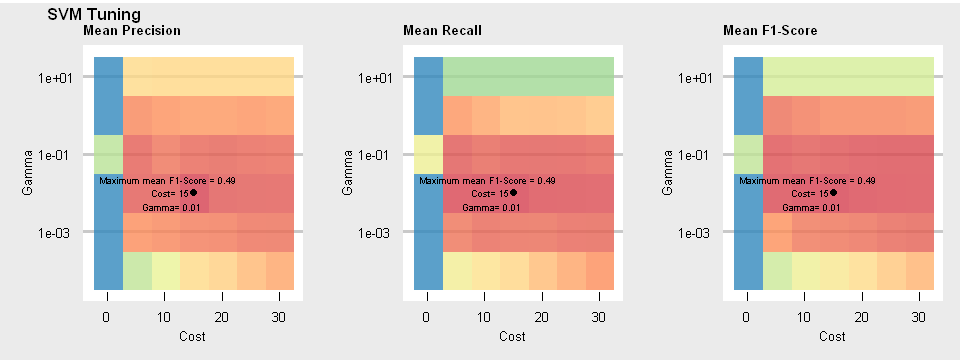

In [11]:
options(repr.plot.width=8, repr.plot.height=3)

# mean precision across wells
g1 <- ggplot(df, aes(cost, gamma, fill=mean_precision)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmax, aes(cost, gamma)) +
    geom_text(aes(x=dfmax$cost[1]-4, y=dfmax$gamma[1], 
                  label=paste("Maximum mean F1-Score =", round(dfmax$mean_f1,2), 
                              "\n Cost=", dfmax$cost[1], "\n Gamma=", dfmax$gamma[1])), 
              size=2) +
    scale_y_log10() +
    labs(x="Cost", y="Gamma", title="Mean Precision") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# mean recall across wells
g2 <- ggplot(df, aes(cost, gamma, fill=mean_recall)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmax, aes(cost, gamma)) +
    geom_text(aes(x=dfmax$cost[1]-4, y=dfmax$gamma[1], 
                  label=paste("Maximum mean F1-Score =", round(dfmax$mean_f1,2), 
                              "\n Cost=", dfmax$cost[1], "\n Gamma=", dfmax$gamma[1])), 
              size=2) +
    scale_y_log10() +
    labs(x="Cost", y="Gamma", title="Mean Recall") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# mean f1-score across wells
g3 <- ggplot(df, aes(cost, gamma, fill=mean_f1)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmax, aes(cost, gamma)) +
    geom_text(aes(x=dfmax$cost[1]-4, y=dfmax$gamma[1], 
                  label=paste("Maximum mean F1-Score =", round(dfmax$mean_f1,2), 
                              "\n Cost=", dfmax$cost[1], "\n Gamma=", dfmax$gamma[1])), 
              size=2) +
    scale_y_log10() +
    labs(x="Cost", y="Gamma", title="Mean F1-Score") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))


# bring two plots together and display
g <- plot_grid(g1, g2, g3, ncol=3)
ggdraw() + 
    draw_plot(g, width=1, height=1, y=-.01) + 
    draw_plot_label("SVM Tuning", size=10)

These raster plots show that our chosen cost and gamma of 15 and 0.01 respectively maximize the overall F1-score (0.49), and appear to be maxima for the overall precision and recall as well.  

## 4 Assessing our training model  

Let's now begin training our model using the optimized tuning parameters.  We'll use our **Well-folds** algorithm to average our metrics, gaining an idea of how the model is performing.  But first, we need to define our training function.

In [25]:
# WARNING: this function will take several minutes to complete
train_svm <- function(train, cv) {

    set.seed(3124)
    
    # build model and predict facies
    fit <- svm(Facies ~ ., data=train, kernel='radial', cost=15, gamma=.01)
    pred <- predict(fit, newdata=cv)

    # evaluate model and store performance
    metrics <- eval_model(pred, cv$Facies)
    data.frame(cost=15, gamma=.01, precision=metrics[1], recall=metrics[2], f1=metrics[3])
}

Our training function (above) takes in a training set and a cross-validation set.  The function builds an SVM model from the training set and applies it to the cross-validation set, returning metrics on the models performance.  Let's apply it to our data!

In [26]:
# apply well-folds to train model
# WARNING: this task can a couple of minutes to complete
train_performance <- well_folds_cv(data, train_svm)
train_performance_round <- train_performance
train_performance_round[,c(1,2,3,4,5)] <- round(train_performance[,c(1,2,3,4,5)],2)
train_performance_round

cost,gamma,precision,recall,f1,well
15,0.01,0.66,0.56,0.52,SHRIMPLIN
15,0.01,0.69,0.58,0.59,LUKE G U
15,0.01,0.25,0.32,0.26,CROSS H CATTLE
15,0.01,0.58,0.55,0.54,NOLAN
15,0.01,0.57,0.52,0.50,NEWBY
15,0.01,0.56,0.52,0.50,CHURCHMAN BIBLE


Interesting!  Our model seems to be performing in the 0.5 through 0.6 **F1-score** range with exception to the **Cross H Cattle** well (we'll worry about this in another notebook).  Let's average these out for an estimated model performance.

In [27]:
round(apply(train_performance[, c(3,4,5)], 2, mean),2)

precision    recall        f1 
     0.55      0.51      0.49

This suggests our training model has an average **F1-score** of 0.49.  Now let's apply the model to the blind data set!

## 5 Applying the model to the blind data set  

Here we will take the previously defined parameters and build a model using the training data and the tuned SVM parameters.  We will then output the overall **precision**, **recall**, and **F1-score**.

In [28]:
set.seed(3124)

# build model and predict facies
fit <- svm(Facies ~ ., data=data[,-c(2,3,4)], kernel='radial', cost=15, gamma=.01)
pred <- predict(fit, newdata=blind)

# evaluate model
cm <- confusionMatrix(pred, blind$Facies)
metrics <- round(accuracy_metrics(as.matrix(cm[["table"]]), blind$Facies),2)
print(paste("Overall Precision:", metrics[1]))
print(paste("Overall Recall:", metrics[2]))
print(paste("Overall F1-score:", metrics[3]))

[1] "Overall Precision: 0.62"
[1] "Overall Recall: 0.46"
[1] "Overall F1-score: 0.43"
